## Регрессия
### Цель
Ваша задача — предсказать цену продажи каждого дома. Для каждого идентификатора в тестовом наборе вам необходимо предсказать значение переменной SalePrice. 

Метрическая
Заявки оцениваются по среднеквадратичной ошибке (RMSE)  между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи. (Логистограммы означают, что ошибки в прогнозировании дорогих и дешевых домов одинаково повлияют на результат.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, norm

In [4]:
from matplotlib import pyplot as plt 
import seaborn as sns

In [5]:
from plots import *
from utils import *

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Описание набора данных
#### Описания файлов

* train.csv — обучающий набор
* test.csv — тестовый набор
* data_description.txt — полное описание каждого столбца, изначально подготовленное Дином Де Коком, но слегка отредактированное, чтобы соответствовать названиям столбцов, используемым здесь
* sample_submission.csv — эталонный отчет, полученный на основе линейной регрессии по году и месяцу продажи, площади участка и количеству спален.


#### Поля данных

* `SalePrice`       — цена продажи недвижимости в долларах. Это целевая переменная, которую вы пытаетесь спрогнозировать.
* `MSSubClass`      : класс здания
* `MSZoning`        : Общая классификация зонирования
* `LotFrontage`     : Линейные футы улицы, прилегающей к участку
* `LotArea`         : Размер участка в квадратных футах
* `Street`          : Тип подъездной дороги
* `Alley`           : Тип доступа к аллее
* `LotShape`        : Общая форма участка
* `LandContour`     : Ровность участка
* `Utilities`       : Тип доступных коммунальных услуг
* `LotConfig`       : Конфигурация лота
* `LandSlope`       : Уклон участка
* `Neighborhood`    : Физические местоположения в пределах города Эймс
* `Condition1`      : Близость к главной дороге или железной дороге
* `Condition2`      : Близость к главной дороге или железной дороге (если есть вторая)
* `BldgType`        : Тип жилища
* `HouseStyle`      : Стиль жилища
* `OverallQual`     : Общее качество материалов и отделки
* `OverallCond`     : Общая оценка состояния
* `YearBuilt`       : Первоначальная дата постройки
* `YearRemodAdd`    : Дата реконструкции
* `RoofStyle`       : Тип крыши
* `RoofMatl`        : Кровельный материал
* `Exterior1st`     : Внешняя отделка дома
* `Exterior2nd`     : Внешняя отделка дома (если используется более одного материала)
* `MasVnrType`      : Тип облицовки каменной кладкой
* `MasVnrArea`      : Площадь облицовки каменной кладкой в ​​квадратных футах
* `ExterQual`       : Качество внешнего материала
* `ExterCond`       : Текущее состояние материала снаружи
* `Foundation`      : Тип фундамента
* `BsmtQual`        : Высота подвала
* `BsmtCond`        : Общее состояние подвала
* `BsmtExposure`    : Стены подвала на уровне выхода или сада
* `BsmtFinType1`    : Качество отделки подвала
* `BsmtFinSF1`      : Тип 1, готовые квадратные футы
* `BsmtFinType2`    : Качество второй обработанной области (если присутствует)
* `BsmtFinSF2`      : Тип 2, готовые квадратные футы
* `BsmtUnfSF`       : Неотделанная площадь подвала в квадратных футах
* `TotalBsmtSF`     : Общая площадь подвала в квадратных футах
* `Heating`         : Тип отопления
* `HeatingQC`       : Качество и состояние отопления
* `CentralAir`      : центральное кондиционирование воздуха
* `Electrical`      : Электрическая система
* `1stFlrSF`        : площадь первого этажа (квадратные футы)
* `2ndFlrSF`        : площадь второго этажа (квадратные футы)
* `LowQualFinSF`    : низкое качество отделки квадратных футов (все этажи)
* `GrLivArea`       : жилая площадь над уровнем земли (квадратные футы)
* `BsmtFullBath`    : Ванные комнаты в подвале
* `BsmtHalfBath`    : Полуванные в подвале
* `FullBath`        : полноценные ванные комнаты выше уровня земли
* `HalfBath`        : Полуванны выше уровня земли
* `Bedroom`         : Количество спален над цокольным этажом
* `Kitchen`         : Количество кухонь
* `KitchenQual`     : Качество кухни
* `TotRmsAbvGrd`    : Общее количество комнат выше уровня земли (без учета ванных комнат)
* `Functional`      : Оценка функциональности дома
* `Fireplaces`      : Количество каминов
* `FireplaceQu`     : Качество камина
* `GarageType`      : Расположение гаража
* `GarageYrBlt`     : Год постройки гаража
* `GarageFinish`    : Внутренняя отделка гаража
* `GarageCars`      : Размер гаража в зависимости от вместимости автомобиля
* `GarageArea`      : Площадь гаража в квадратных футах
* `GarageQual`      : Качество гаража
* `GarageCond`      : Состояние гаража
* `PavedDrive`      : Асфальтированная подъездная дорога
* `WoodDeckSF`      : Площадь деревянной террасы в квадратных футах
* `OpenPorchSF`     : Площадь открытой веранды в квадратных футах
* `EnclosedPorch`   : Площадь закрытой веранды в квадратных футах
* `3SsnPorch`       : Площадь крыльца, рассчитанного на три сезона, в квадратных футах
* `ScreenPorch`     : Площадь веранды в квадратных футах
* `PoolArea`        : Площадь бассейна в квадратных футах
* `PoolQC`          : Качество пула
* `Fence`           : Качество забора
* `MiscFeature`     : Разные функции, не охваченные другими категориями.
* `MiscVal`         : $Value разного признака
* `MoSold`          : Месяц продаж
* `YrSold`          : Год продажи
* `SaleType`        : Тип продажи
* `SaleCondition`   : Состояние продажи

In [7]:
SEED = 42

### 1. Загрузка данных

In [8]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

Для предобработки и анализа данных, лучше использовать единный датасет.

In [9]:
print(f'Размер train: {train.shape}')
print(f'Размер test: {test.shape}')

Размер train: (1460, 81)
Размер test: (1459, 80)


Заметим, что отсутствует некий столбец в test и предварительно можно оценить что это `SalePrice` - целевая переменная.

In [10]:
missing_columns = set(train.columns) - set(test.columns)
missing_columns = ", ".join(missing_columns)
print(missing_columns)

SalePrice


Уберем `SalePrice` в X_train для обработки.

In [11]:
X_train = train.drop(columns=[missing_columns])
y_train = train[['Id', missing_columns]]
X_test = test

Соединим train и test.

In [12]:
sum_line = X_train.shape[0] + X_test.shape[0]
try:
    data = pd.concat([X_train, X_test])
    data = data.reset_index(drop=True)
    if sum_line == data.shape[0]:
        print(f'Теорический размер data: {sum_line}')
        print(f'Фактический размер data: {data.shape[0]}')
    else:
        print(f'Размеры не совпадают!')
except Exception as e:
    print(f'Ошибка при объединении данных {e}.')

Теорический размер data: 2919
Фактический размер data: 2919


In [13]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [14]:
data.tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,NaN,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Наблюдаем большое количество пропущенных значений, которые надо преобработать, при этом тип данных указан правильно.                     

### 2. Предобработка данных

#### 2.1. Проверка на дубликаты

In [16]:
data.duplicated().sum()

0

Дубликаты отсутствуют, проверим пропущенные значения.

#### 2.2. Проверка на пропущенные значения

In [17]:
miss_val = get_missing(data)
display(miss_val)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtUnfSF          1
GarageArea         1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
Electrical         1
KitchenQual        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
dtype: int64

Выведем долю пропущенных значений.

In [18]:
ratio = data.isna().mean().sort_values(ascending=False)
ratio = ratio[ratio > 0]
print(ratio)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
MasVnrType      0.605002
FireplaceQu     0.486468
LotFrontage     0.166495
GarageQual      0.054471
GarageCond      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Functional      0.000685
Utilities       0.000685
BsmtUnfSF       0.000343
GarageArea      0.000343
Exterior1st     0.000343
Exterior2nd     0.000343
TotalBsmtSF     0.000343
GarageCars      0.000343
Electrical      0.000343
KitchenQual     0.000343
SaleType        0.000343
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
dtype: float64


Топ 7 фичей с пропусков более 10%, поэтому стоит обратить на них особое внимание.

### 3. Детальное изучение признаков

`Id`

Видим, что столбец `Id` не несет пользы, т.к. он инкремент, поэтому нужно избавиться от него, но при нему будем восстанавлить X_train и y_train. Удалим `Id` после объединения.

In [19]:
#data = data.drop(columns=['Id'], axis=1)

##### 3.1. Категориальные переменные c пропусками

Сначала избавимся от строк, где данных пропущено меньше чем на 10.

In [20]:
drop_columns_ten = miss_val[miss_val < 10].index

In [21]:
drop_columns_ten

Index(['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'Utilities',
       'BsmtUnfSF', 'GarageArea', 'Exterior1st', 'Exterior2nd', 'TotalBsmtSF',
       'GarageCars', 'Electrical', 'KitchenQual', 'SaleType', 'BsmtFinSF1',
       'BsmtFinSF2'],
      dtype='object')

In [22]:
data = data.dropna(subset=drop_columns_ten)

Теперь рассмотрим столбцы у которых количество пропущенных значений в диапазоне от 10 до 1000. Их заполним меткой unknown.

In [23]:
drop_columns_th = miss_val[(miss_val >= 10) & (miss_val < 1000)].index
object_col_th = [col for col in drop_columns_th if data[col].dtype == 'object']

In [24]:
object_col_th

['GarageQual',
 'GarageCond',
 'GarageFinish',
 'GarageType',
 'BsmtExposure',
 'BsmtCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1']

In [25]:
for col in object_col_th:
    data[col] = data[col].fillna('unknown')

Рассмотрим детально столбцы, где пропуски составляют более 1000 значений.

In [26]:
drop_columns = miss_val[miss_val >= 1000].index
object_col = [col for col in drop_columns if data[col].dtype == 'object']

In [27]:
object_col

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

`PoolQC` `MiscFeature`

In [28]:
ratio[:2]

PoolQC         0.996574
MiscFeature    0.964029
dtype: float64

Данные настолько сильно повреждены, что восстановить не представляется возможным.

In [29]:
data = data.drop(columns=['PoolQC', 'MiscFeature'], axis=1)

`Alley` - Тип доступа к аллее

In [30]:
data['Alley'].value_counts()

Alley
Grvl    119
Pave     78
Name: count, dtype: int64

После предобработки будем фиксировать количество пропущенных данных.

In [31]:
missing_alley = pd.DataFrame(data['Alley'].value_counts())

* Grvl — Гравийный проезд.
* Pave — Плиточный/асфальтированный проезд.

Сделаем срез по значениям `Alley`.

In [32]:
data_grvl = data[data['Alley'] == data['Alley'].value_counts().index[0]]
data_pave = data[data['Alley'] == data['Alley'].value_counts().index[1]]

Рассмотрим, что выдает grvl и pave в данных для их восстановления.

In [33]:
data_gp = pd.concat([data_grvl[:5], data_pave[:5]])
display(data_gp)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Unf,7,7,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,0.0,637.0,637.0,GasA,Ex,Y,FuseF,1108,0,0,1108,0.0,0.0,1,0,3,1,Gd,6,Typ,1,Gd,Attchd,1930.0,Unf,1.0,280.0,TA,TA,N,0,0,205,0,0,0,GdPrv,0,6,2007,WD,Normal
79,80,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,6,1910,1981,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,0.0,440.0,440.0,GasA,Gd,Y,SBrkr,682,548,0,1230,0.0,0.0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1966.0,Unf,2.0,440.0,TA,TA,Y,74,0,128,0,0,0,MnPrv,0,5,2009,WD,Normal
92,93,30,RL,80.0,13360,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,5,7,1921,2006,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,Gd,BrkTil,Gd,TA,No,ALQ,713.0,Unf,0.0,163.0,876.0,GasA,Ex,Y,SBrkr,964,0,0,964,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1921.0,Unf,2.0,432.0,TA,TA,Y,0,0,44,0,0,0,NaN,0,8,2009,WD,Normal
106,107,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,1885,1995,Mansard,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,641.0,641.0,GasA,Gd,Y,SBrkr,1047,0,0,1047,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1954.0,Unf,1.0,273.0,Fa,Fa,N,0,0,0,0,0,0,NaN,450,8,2007,WD,Normal
204,205,50,RM,50.0,3500,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,7,1947,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,TA,TA,CBlock,TA,TA,No,LwQ,312.0,Unf,0.0,408.0,720.0,GasA,TA,Y,SBrkr,720,564,0,1284,0.0,0.0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1948.0,Unf,1.0,240.0,TA,TA,Y,0,35,0,0,0,0,MnWw,0,4,2009,WD,Normal
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,NaN,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,649.0,649.0,GasA,TA,N,SBrkr,649,668,0,1317,0.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1.0,250.0,TA,Fa,N,0,54,172,0,0,0,MnPrv,0,7,2008,WD,Normal
56,57,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,No,GLQ,649.0,Unf,0.0,321.0,970.0,GasA,Ex,Y,SBrkr,983,756,0,1739,1.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1999.0,Fin,2.0,480.0,TA,TA,Y,115,0,0,0,0,0,NaN,0,8,2009,WD,Abnorml
87,88,160,FV,40.0,3951,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,612.0,612.0,GasA,Ex,Y,SBrkr,612,612,0,1224,0.0,0.0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2009.0,RFn,2.0,528.0,TA,TA,Y,0,234,0,0,0,0,NaN,0,6,2009,New,Partial
115,116,160,FV,34.0,3230,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,1999,1999,Gable,CompShg,MetalSd,MetalSd,BrkFace,1129.0,TA,TA,PConc,Gd,TA,No,GLQ,419.0,Unf,0.0,310.0,729.0,GasA,Gd,Y,SBrkr,729,729,0,1458,0.0,0.0,2,1,2,1,TA,5,Typ,1,Fa,Detchd,1999.0,Unf,2.0,440.0,TA,TA,Y,0,32,0,0,0,0,NaN,0,6,2007,WD,Normal
164,165,40,RM,40.0,5400,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,7,1926,2004,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,Mn,LwQ,370.0,Unf,0.0,779.0,1149.0,GasA,Gd

In [34]:
del data_gp

Посмотрим разницу домов по общей классификации зонирования.

In [35]:
datasets_zone = {
    "grvl": data_grvl['MSZoning'],
    "pave": data_pave['MSZoning']
}

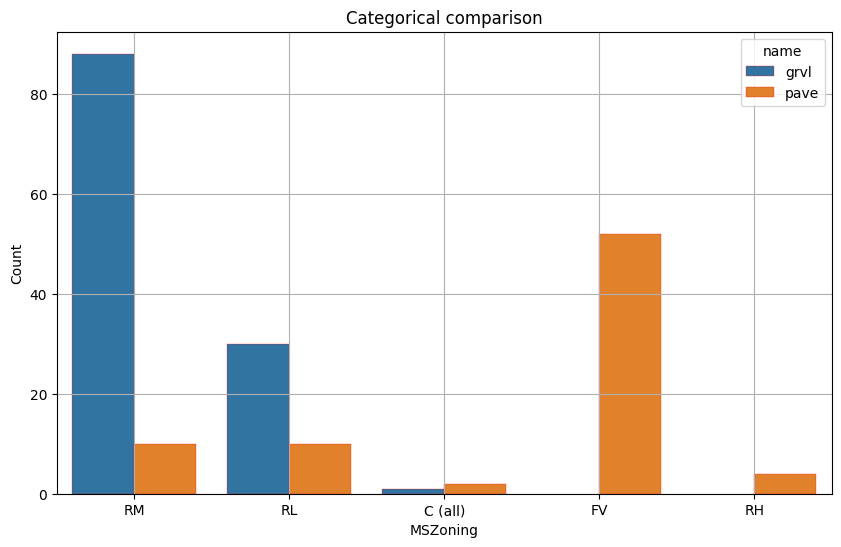

In [36]:
BuildHist(datasets_zone).categorical_hist()

In [37]:
del datasets_zone

Мы можем восстановить часть данных заполнив Alley со значением pave по MSZoning со значениями FV и RH.

In [38]:
data.loc[data['MSZoning'] == 'FV', 'Alley'] = 'Pave'
data.loc[data['MSZoning'] == 'RH', 'Alley'] = 'Pave'

In [39]:
missing_alley['MSZoning'] = data['Alley'].value_counts()

Рассмотрим возможность восстановления данных по году постройки.

In [40]:
datasets_year = {
    "grvl": data_grvl['YearBuilt'],
    "pave": data_pave['YearBuilt']
}

In [41]:
type(datasets_year)

dict

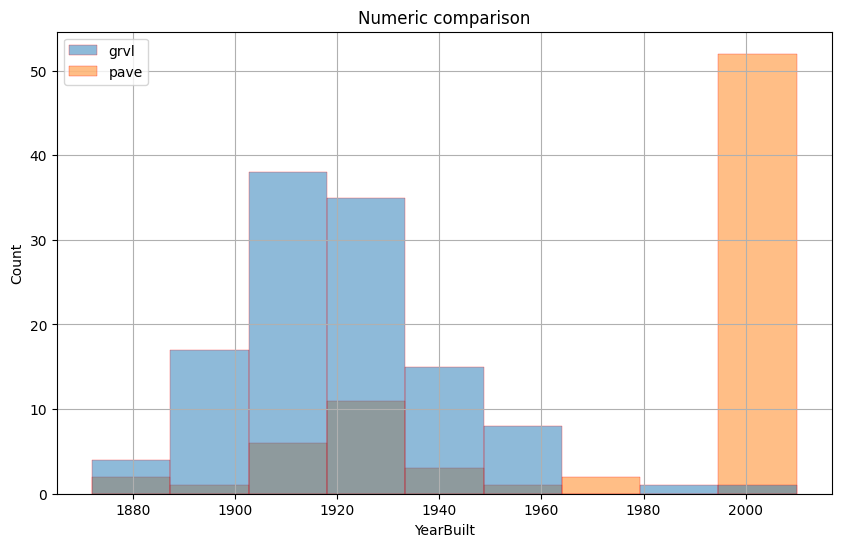

In [42]:
BuildHist(datasets_year).numeric_plot()

In [43]:
del datasets_year

Заметим, что после 1980 года, с большой уверенностью, можем восстановить Alley со значением Pave.

In [44]:
data.loc[(data['YearBuilt'] >= 1980) & (data['Alley'].isna()), 'Alley'] = 'Pave'

In [45]:
missing_alley['YearBuilt'] = data['Alley'].value_counts()

Так же рассмотрим по году постройке гаража. 

In [46]:
datasets_garage = {
    "grvl": data_grvl['GarageYrBlt'],
    "pave": data_pave['GarageYrBlt']
}

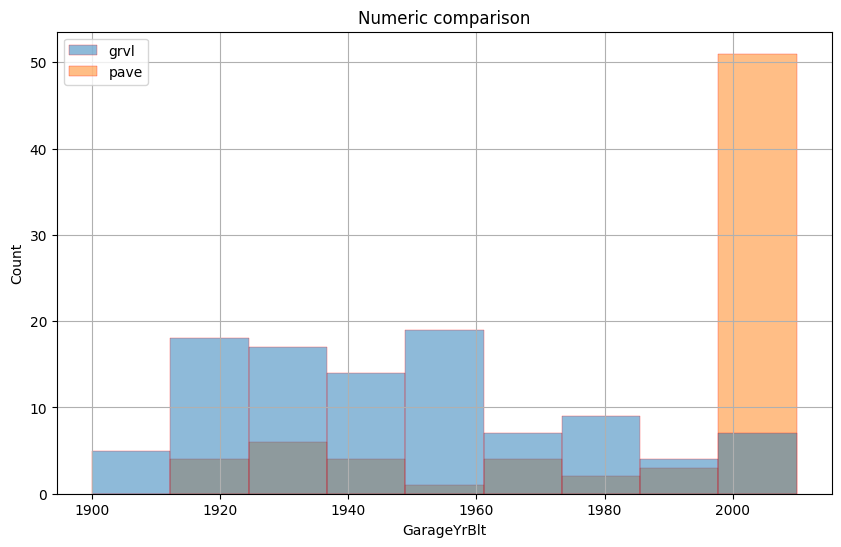

In [47]:
BuildHist(datasets_garage).numeric_plot()

In [48]:
del datasets_garage

Так же восстановим по гаражу после 2000 года.

In [49]:
data.loc[(data['GarageYrBlt'] >= 2000) & (data['Alley'].isna()), 'Alley'] = 'Pave'

In [50]:
missing_alley['GarageYrBlt'] = data['Alley'].value_counts()

Попробуем восстановить данные по соседям.

In [51]:
datasets_neighborhood = {
    "grvl": data_grvl['Neighborhood'],
    "pave": data_pave['Neighborhood']
}

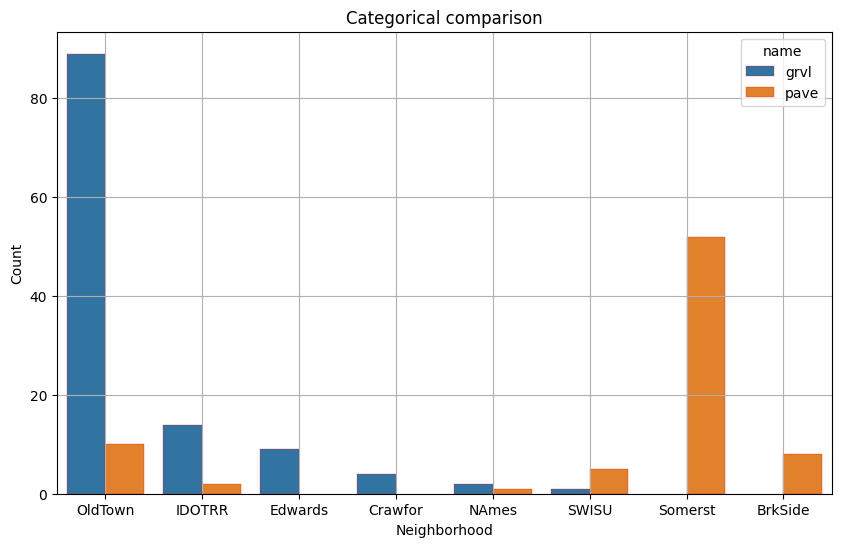

In [52]:
BuildHist(datasets_neighborhood).categorical_hist()

In [53]:
del datasets_neighborhood

Восстановим данные там, где однозначено определено значение по столбцу.

In [54]:
data.loc[(data['Neighborhood'] == 'Crawfor') & (data['Alley'].isna()), 'Alley'] = 'Grvl'
data.loc[(data['Neighborhood'] == 'Edwards') & (data['Alley'].isna()), 'Alley'] = 'Grvl'
data.loc[(data['Neighborhood'] == 'Somerst') & (data['Alley'].isna()), 'Alley'] = 'Pave'
data.loc[(data['Neighborhood'] == 'BrkSide') & (data['Alley'].isna()), 'Alley'] = 'Pave'

In [55]:
missing_alley['Neighborhood'] = data['Alley'].value_counts()

In [56]:
display(missing_alley)

,count,MSZoning,YearBuilt,GarageYrBlt,Neighborhood
Alley,,,,,
Grvl,119,119,119,119,346
Pave,78,187,1268,1292,1388


In [57]:
del missing_alley

In [58]:
data['Alley'].isna().sum()

1172

Осталось 1176 данных, которые сложно восстановить, поэтому добавим метку unknown.

In [59]:
data.loc[data['Alley'].isna(), 'Alley'] = 'unknown'

`MasVnrType` - Тип облицовки каменной кладкой

In [60]:
data['MasVnrType'].value_counts()

MasVnrType
BrkFace    878
Stone      249
BrkCmn      25
Name: count, dtype: int64

* BrkFace — облицовочный кирпич
* Stone — Каменная облицовка
* BrkCmn — обычный строительный кирпич

Посмотрим насколько они отличаются по стоимости.

In [61]:
data_f = train.loc[train['MasVnrType'] == train['MasVnrType'].value_counts().index[0]]
data_s = train.loc[train['MasVnrType'] == train['MasVnrType'].value_counts().index[1]]


In [62]:
datasets_vnr = {
    "BrkFace": data_f['SalePrice'],
    "Stone": data_s['SalePrice']
}

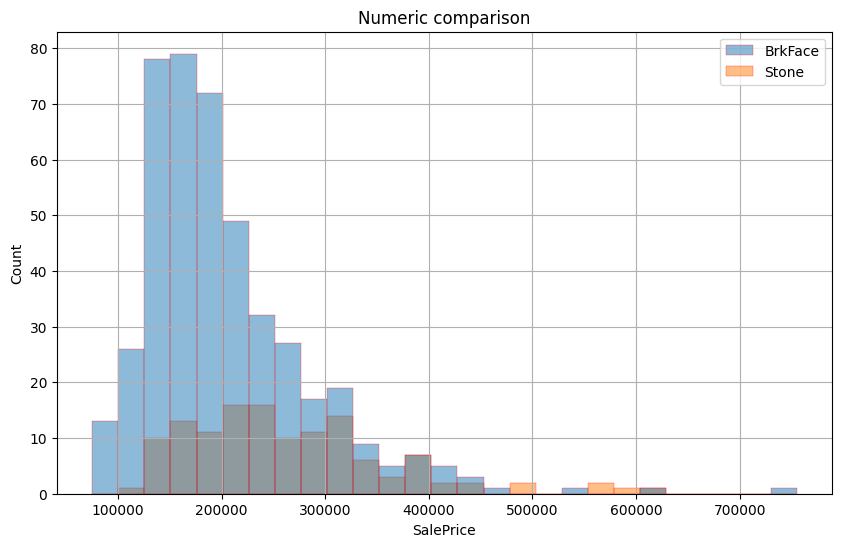

In [63]:
BuildHist(datasets_vnr).numeric_plot()

In [64]:
del data_f
del data_s

Стоимость практически одинаковая, поэтому неизвестным строкам поставим метку unknown. Но следует детальнее рассмотреть данные после 650.000, т.к. это может являться просто дорогим жильем, а может быть и выбросом.

In [65]:
data.loc[data['MasVnrType'].isna(), 'MasVnrType'] = 'unknown'

In [66]:
train.loc[train['SalePrice'] > 650000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,NaN,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [67]:
print(f'Средняя площадь: {round(data['LotArea'].mean(), 2)}')

Средняя площадь: 10116.75


По площади можно заметить, что это не выбросы.

`Fence` - Забор

In [68]:
data['Fence'].value_counts()

Fence
MnPrv    327
GdPrv    118
GdWo     112
MnWw      12
Name: count, dtype: int64

MnPrv — среднее качество ограды.

GdPrv — хорошее качество ограды.

GdWo — хорошая ограда без покрытия (без покрытия или "без обработки").

MnWw — низкое качество ограды.

Скорее всего если данных нет, то забор отсутствует.

In [69]:
data['Fence'] = data['Fence'].fillna('NoFence')

`FireplaceQu` - Качество камина

In [70]:
data['FireplaceQu'].value_counts()

FireplaceQu
Gd    740
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

Gd — Good (хорошее качество камина).

TA — Typical Average (среднее стандартное качество камина).

Fa — Fair (небольшое ухудшение, камин в среднем состоянии).

Po — Poor (плохое качество камина).

Ex — Excellent (отличное качество камина).

Скорее всего пропуски в этих данных означает отсутствие камина.

In [71]:
data['Fireplaces'][data['FireplaceQu'].isna()].mean()

0.0

Все верно, среднее значение каминов при пропущенных данных в FireplaceQu, говорит о отсутствии камина.

In [72]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('NoFireplace')

##### 3.2. Количественные переменные c пропусками

In [73]:
miss_val = get_missing(data)
display(miss_val)

LotFrontage    484
GarageYrBlt    157
MasVnrArea      23
dtype: int64

In [74]:
numeric_col = [col for col in miss_val.index]

In [75]:
numeric_col

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

`LotFrontage` - Линейные футы улицы, прилегающей к участку

Посмотрим распредение LotFrontage.

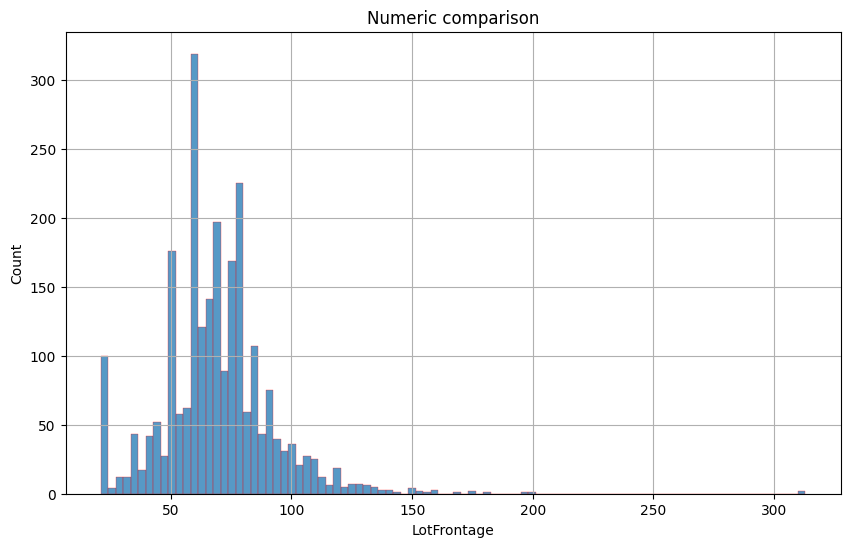

In [76]:
BuildHist(data['LotFrontage']).numeric_plot()

Так же посмотрим на выбросы.

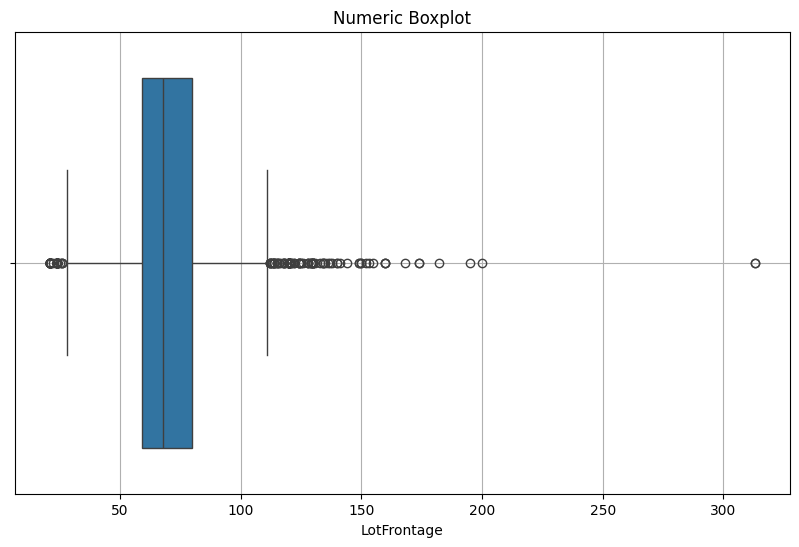

In [77]:
BuildHist(data['LotFrontage']).numeric_boxplot()

In [78]:
train.loc[train['LotFrontage'] > 200]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,425,Unf,0,160,585,GasA,Ex,Y,SBrkr,2069,0,0,2069,1,0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.0,RFn,2,505,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [79]:
round(y_train.mean(), 2)

Id              730.5
SalePrice    180921.2
dtype: float64

Такие участки действительно могут существовать, т.к. датасет по данным из США.

In [80]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())

`MasVnrArea` - Площадь облицовки каменной кладкой в ​​квадратных футах  

Посмотрим распределение MasVnrArea.

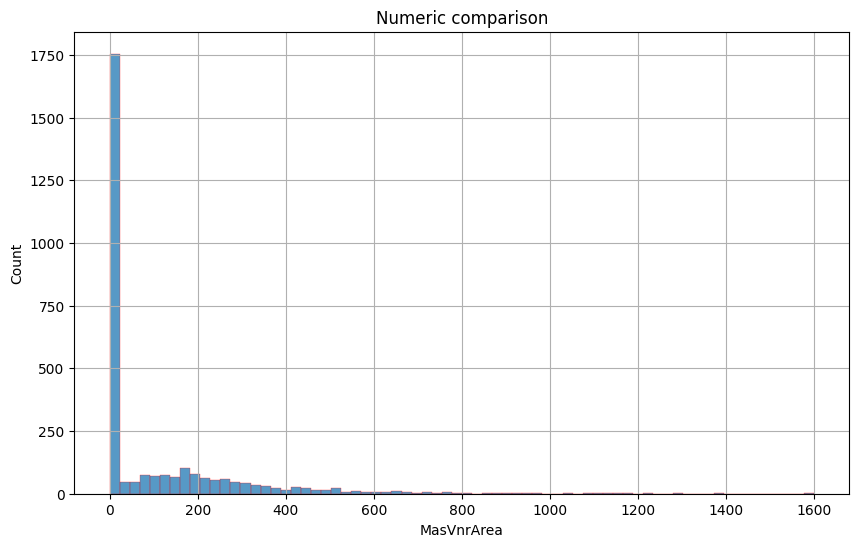

In [81]:
BuildHist(data['MasVnrArea']).numeric_plot()

Посмотрим выбросы MasVnrArea

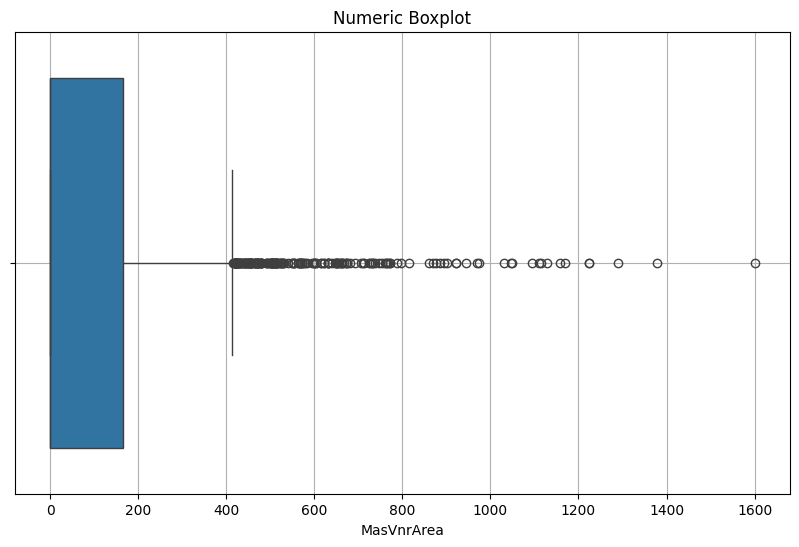

In [82]:
BuildHist(data['MasVnrArea']).numeric_boxplot()

Посмотрим параметры здания у которых MasVnrArea более 1000.

In [83]:
train.loc[train['MasVnrArea'] > 1000, ['MasVnrArea', 'MasVnrType', 'LotArea', 'YearBuilt', 'SalePrice']]

,MasVnrArea,MasVnrType,LotArea,YearBuilt,SalePrice
58,1031.0,BrkFace,13682,2006,438780
70,1115.0,BrkFace,13651,1973,244000
115,1129.0,BrkFace,3230,1999,176000
297,1600.0,BrkFace,7399,1997,239000
691,1170.0,BrkFace,21535,1994,755000
808,1047.0,BrkFace,13400,1966,159950
1169,1378.0,BrkFace,35760,1995,625000


Скорее всего данные с индексами 115 и 297 являются выбросами.

In [84]:
data = data.drop(index=[115, 297])

`GarageYrBlt` - Год постройки гаража

In [85]:
missing_year = data.loc[data['GarageYrBlt'].isna(), ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageCond']]

In [86]:
missing_year.head(5)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageCond
39,0.0,0.0,unknown,unknown,unknown,unknown
48,0.0,0.0,unknown,unknown,unknown,unknown
78,0.0,0.0,unknown,unknown,unknown,unknown
88,0.0,0.0,unknown,unknown,unknown,unknown
89,0.0,0.0,unknown,unknown,unknown,unknown


In [87]:
print(missing_year['GarageArea'].mean())
print(missing_year['GarageCars'].mean())

2.2929936305732483
0.006369426751592357


Эти строки не представляют интереса.

In [88]:
data = data.dropna(subset=['GarageYrBlt'])

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2747 entries, 0 to 2918
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2747 non-null   int64  
 1   MSSubClass     2747 non-null   int64  
 2   MSZoning       2747 non-null   object 
 3   LotFrontage    2747 non-null   float64
 4   LotArea        2747 non-null   int64  
 5   Street         2747 non-null   object 
 6   Alley          2747 non-null   object 
 7   LotShape       2747 non-null   object 
 8   LandContour    2747 non-null   object 
 9   Utilities      2747 non-null   object 
 10  LotConfig      2747 non-null   object 
 11  LandSlope      2747 non-null   object 
 12  Neighborhood   2747 non-null   object 
 13  Condition1     2747 non-null   object 
 14  Condition2     2747 non-null   object 
 15  BldgType       2747 non-null   object 
 16  HouseStyle     2747 non-null   object 
 17  OverallQual    2747 non-null   int64  
 18  OverallCond  

Данные предобработаны. Далее надо проверить важность столбцов.

#### 3.3. Оценка значений

In [90]:
X_train_merge = data.merge(y_train, on='Id', how='left').drop(columns=['Id'])

In [91]:
X_test_merge = X_train_merge[X_train_merge['SalePrice'].isna()]

In [92]:
X_train_merge = X_train_merge.dropna()

In [93]:
y_train_merge = X_train_merge['SalePrice']
X_train_merge = X_train_merge.drop(columns=['SalePrice'])

Выясним какие столбцы с категориальными переменными, а какие с количественными.

In [94]:
numeric_columns = X_train_merge.select_dtypes(include=['int', 'float']).columns.to_list()
categorical_columns = X_train_merge.select_dtypes(exclude=['int', 'float']).columns.to_list()

In [95]:
pre = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

Подготовим пайплайн.

In [96]:
baseline = Pipeline([
    ('prep', pre),
    ('clf', RandomForestRegressor(n_jobs=-1))
])

Выполним кросс-валидацию.

In [97]:
cv = KFold(n_splits=5, random_state=SEED, shuffle=True)

Подготовим параметры перед обучением.

In [98]:
search_params = {
    'clf__n_estimators' : randint(20, 100),
    'clf__max_depth' : randint(3, 12)
}

Обучим модель.

In [99]:
search = RandomizedSearchCV(baseline, cv=cv, param_distributions=search_params, n_jobs=-1, scoring='neg_mean_squared_error', error_score='raise')

In [100]:
search.fit(X_train_merge, y_train_merge)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['MSSubClass',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'BsmtFinSF1',
                                                                                'BsmtFinSF2',
                                                                                'BsmtUnfSF',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrSF',
                                                                                '2...
                                                                                'HeatingQC',
                                                                                'CentralAir',
                                                                                'Electrical', ...])])),
                                             ('clf',
                                              RandomForestRegressor(n_jobs=-1))]),
                   n_jobs=-1,
                   param_distributions={'clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D81277B530>,
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D81277A540>},
                   scoring='neg_mean_squared_error')

In [101]:
print(search.best_params_)
print(search.best_score_)

{'clf__max_depth': 10, 'clf__n_estimators': 68}
-837239524.2197171


Оценим важность признаков.

In [102]:
importance = permutation_importance(search, X_train_merge, y_train_merge, n_repeats=30, random_state=SEED, n_jobs=-1)

In [103]:
imp = pd.DataFrame(importance.importances_mean, index=X_train_merge.columns, columns=['Importance']).sort_values(by=['Importance'], ascending=False)
imp['Importance'] = imp['Importance'].apply(lambda x: f'{x:.2f}')

In [104]:
imp

,Importance
OverallQual,3374965760.48
GrLivArea,1112448211.14
BsmtFinSF1,210486426.23
TotalBsmtSF,196335076.95
2ndFlrSF,138560799.03
1stFlrSF,90466986.93
GarageCars,75619041.93
LotArea,62432098.73
GarageArea,53791436.68
YearBuilt,53395074.09
